In [1]:
#Stu no: 99210259
#stu name: Amir Pourmand

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [25]:
cuda = torch.device('cuda')

In [2]:
 !wget https://github.com/mralisoltani/CNN_Tumor/raw/main/Tumor.zip


--2021-12-04 19:48:40--  https://github.com/mralisoltani/CNN_Tumor/raw/main/Tumor.zip
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mralisoltani/CNN_Tumor/main/Tumor.zip [following]
--2021-12-04 19:48:40--  https://raw.githubusercontent.com/mralisoltani/CNN_Tumor/main/Tumor.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14338568 (14M) [application/zip]
Saving to: ‘Tumor.zip’

Tumor.zip           100%[===================>]  13.67M  --.-KB/s    in 0.1s    

2021-12-04 19:48:42 (102 MB/s) - ‘Tumor.zip’ saved [14338568/14338568]



In [ ]:
!unzip /content/Tumor.zip


In [74]:
# -*- coding: utf-8 -*-
"""

@author: Ali Soltani
"""


import torch
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import pandas as pds
from torch.utils.data import DataLoader,TensorDataset,random_split

############################################################## Loading Data
n = 3762
image=[]
cw = os.getcwd().replace(os.sep, '/')
trans = transforms.Compose([transforms.ToTensor()])
for i in range(n):
#    image.append(np.asarray(Image.open(cw + "/Brain_Tumor/Image" + str(i+1) + ".jpg")))
    image.append(np.array(Image.open(cw + "/Brain_Tumor/Image" + str(i+1) + ".jpg").resize((48,48))))

temp = pds.read_csv(cw + "/Brain_Tumor.csv",index_col=None, header=None).to_numpy()
temp = temp[1:,1]
targets = np.zeros((n,1),dtype=int)
targets = []
for i in range(n):
    targets.append(int(temp[i]))

data = np.array(image)
data = data/255
data = torch.from_numpy(data).permute((0,3,2,1))
data = data.float().to(cuda)
targets = torch.tensor(targets).to(cuda)
dataset = TensorDataset(data,targets)
batch_size = 4
val_size = int(np.ceil(len(dataset)*0.2))
train_size = len(dataset) - val_size 

train_data,test_data = random_split(dataset,[train_size,val_size])


train_loader = DataLoader(train_data,batch_size = batch_size,shuffle=True)
test_loader = DataLoader(test_data,batch_size = batch_size,shuffle=True)

In [29]:
import matplotlib.pyplot as plt
from torchvision import transforms

count of data: 3009
Feature batch shape: torch.Size([4, 3, 48, 48])
Labels batch shape: torch.Size([4])


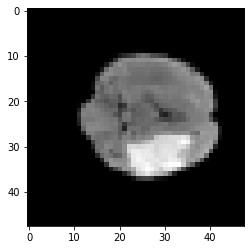

Label: 1


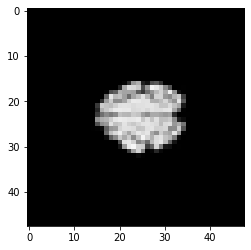

Label: 0


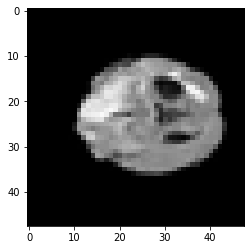

Label: 1


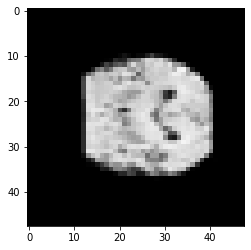

Label: 0


In [30]:
print("count of data:", len(train_data))
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

for i in range(batch_size):
    img = train_features[i].squeeze()
    label = train_labels[i]
    im = transforms.ToPILImage()(img).convert("RGB")
    plt.imshow(im)
    plt.show()
    print(f"Label: {label}")

In [7]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*48*48, 512),
            nn.ReLU(),
            nn.Linear(512, 24),
            nn.ReLU(),
            nn.Linear(24, 2),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Using cuda device


In [56]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=6912, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=2, bias=True)
  )
)


In [57]:
learning_rate = 1e-3
batch_size = 64
epochs = 100

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [58]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [59]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

losses=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    loss = test_loop(test_loader, model, loss_fn)
    losses.append(loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.612874  [    0/ 3009]
loss: 0.712673  [  400/ 3009]
loss: 0.744615  [  800/ 3009]
loss: 0.690195  [ 1200/ 3009]
loss: 0.710857  [ 1600/ 3009]
loss: 0.616541  [ 2000/ 3009]
loss: 0.650407  [ 2400/ 3009]
loss: 0.670259  [ 2800/ 3009]
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.609731 

Epoch 2
-------------------------------
loss: 0.610377  [    0/ 3009]
loss: 0.635636  [  400/ 3009]
loss: 0.459467  [  800/ 3009]
loss: 0.638018  [ 1200/ 3009]
loss: 0.553621  [ 1600/ 3009]
loss: 0.758643  [ 2000/ 3009]
loss: 0.648250  [ 2400/ 3009]
loss: 0.499889  [ 2800/ 3009]
Test Error: 
 Accuracy: 79.0%, Avg loss: 0.501841 

Epoch 3
-------------------------------
loss: 0.425109  [    0/ 3009]
loss: 0.521330  [  400/ 3009]
loss: 0.658485  [  800/ 3009]
loss: 0.244719  [ 1200/ 3009]
loss: 0.252357  [ 1600/ 3009]
loss: 0.307023  [ 2000/ 3009]
loss: 0.536315  [ 2400/ 3009]
loss: 0.851961  [ 2800/ 3009]
Test Error: 
 Accuracy: 80.1%, Avg loss: 0.463312 

Epoc

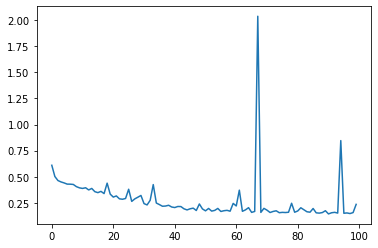

In [60]:
plt.plot(np.arange(0,100),losses)

In [88]:
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super(NeuralNetwork2, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(36864,512),
            nn.ReLU(),
            nn.Linear(512,24),
            nn.ReLU(),
            nn.Linear(24,2)
        )

    def forward(self, x):
        logits = self.stack(x)
        return logits

In [89]:
model2 = NeuralNetwork2().to(cuda)
print(model2)

NeuralNetwork2(
  (stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=36864, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=24, bias=True)
    (9): ReLU()
    (10): Linear(in_features=24, out_features=2, bias=True)
  )
)


In [90]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate)

losses=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model2, loss_fn, optimizer)
    loss = test_loop(test_loader, model2, loss_fn)
    losses.append(loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.711715  [    0/ 3009]
loss: 0.705897  [  400/ 3009]
loss: 0.781048  [  800/ 3009]
loss: 0.708077  [ 1200/ 3009]
loss: 0.695257  [ 1600/ 3009]
loss: 0.691893  [ 2000/ 3009]
loss: 0.693443  [ 2400/ 3009]
loss: 0.642027  [ 2800/ 3009]
Test Error: 
 Accuracy: 56.2%, Avg loss: 0.673766 

Epoch 2
-------------------------------
loss: 0.755350  [    0/ 3009]
loss: 0.700148  [  400/ 3009]
loss: 0.718120  [  800/ 3009]
loss: 0.629210  [ 1200/ 3009]
loss: 0.644932  [ 1600/ 3009]
loss: 0.655081  [ 2000/ 3009]
loss: 0.669446  [ 2400/ 3009]
loss: 0.587303  [ 2800/ 3009]
Test Error: 
 Accuracy: 62.3%, Avg loss: 0.640227 

Epoch 3
-------------------------------
loss: 0.762679  [    0/ 3009]
loss: 0.626614  [  400/ 3009]
loss: 0.748828  [  800/ 3009]
loss: 0.653227  [ 1200/ 3009]
loss: 0.678577  [ 1600/ 3009]
loss: 0.457607  [ 2000/ 3009]
loss: 0.869075  [ 2400/ 3009]
loss: 0.577134  [ 2800/ 3009]
Test Error: 
 Accuracy: 76.1%, Avg loss: 0.556132 

Epoc

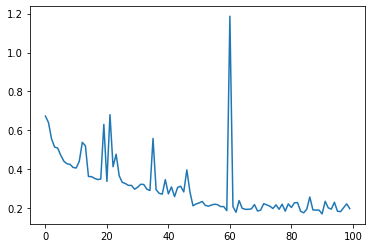

In [91]:
plt.plot(np.arange(0,100),losses)

In [92]:
# accuracy is better. and in first one the model is overfitted and it will not get better accuracy 
# but in second one as time goes, it is possible that it gets better accuracy and lower loss. 